<a id='SimulatedDataEnsembleModelsTop'></a>
# Train Ensemble of LSTM Network Models on Simulated Training Set

Investigating utility of training an ensemble of LSTM models on large simulated dataset, to later be evaluated on the experimental dataset

- Architecture, informed by limited [hyperparameter tuning](SimulatedDataPretrainedModelTuner.ipynb#SimulatedDataPretrainedModelTunerTop) with keras tuner, is:
    - input layer - 50
    - hidden layer - 200
    - hidden layer - 50
    - hidden layer - 10
    - output layer - 2 (softplus activation, to ensure variance predictions are positive)
- batch size = 64
- Number of base learners in ensemble = 10
- 3:1:1 train:validation:test dataset split
- 2000 epochs

The model from the epoch which gives the best validation loss is saved for future use, for making predictions on the previously unseen experimental test set

Minimum loss is -ln(minimum_variance)/2 = -6.91 (for a minimum variance chosen to be 1e-6)

model number 1


/home/simonjward/Desktop/ResponseTimeReduction/Python/LSTMutils.py:28: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_full = pd.read_csv(self.ExperimentalDataFilePath,sep=',',header=None,index_col=ConcentrationAsIndex)


Epoch 1/2
127/127 [==============================] - ETA: 0s - loss: -1.2881

INFO:tensorflow:Assets written to: ../ModelsTest/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel1/assets


INFO:tensorflow:Assets written to: ../ModelsTest/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel1/assets


127/127 [==============================] - 32s 234ms/step - loss: -1.2881 - val_loss: -1.9855
Epoch 2/2
127/127 [==============================] - ETA: 0s - loss: -2.3030

INFO:tensorflow:Assets written to: ../ModelsTest/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel1/assets


INFO:tensorflow:Assets written to: ../ModelsTest/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel1/assets


127/127 [==============================] - 29s 228ms/step - loss: -2.3030 - val_loss: -2.5742


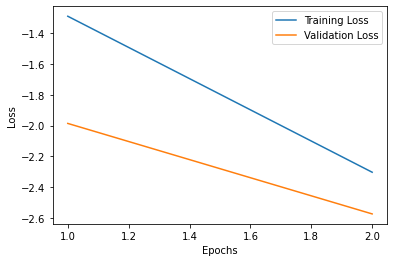

141/141 [==============================] - 7s 42ms/step - loss: -2.5736
1 models complete
model number 2


Epoch 1/2
127/127 [==============================] - ETA: 0s - loss: -0.6965

INFO:tensorflow:Assets written to: ../ModelsTest/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel2/assets


INFO:tensorflow:Assets written to: ../ModelsTest/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel2/assets


127/127 [==============================] - 32s 231ms/step - loss: -0.6965 - val_loss: -0.9513
Epoch 2/2
127/127 [==============================] - ETA: 0s - loss: -0.9533

INFO:tensorflow:Assets written to: ../ModelsTest/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel2/assets


INFO:tensorflow:Assets written to: ../ModelsTest/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel2/assets


127/127 [==============================] - 29s 228ms/step - loss: -0.9533 - val_loss: -0.9668


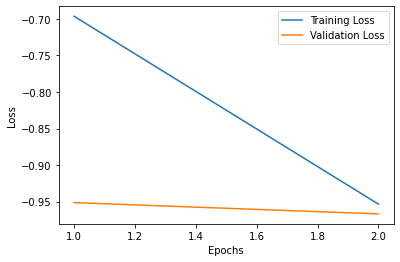

141/141 [==============================] - 7s 42ms/step - loss: -0.9595
2 models complete


In [2]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import math
from LSTMutils import MeanVarianceLogLikelyhoodLoss
from sklearn.model_selection import train_test_split
import LSTMutils

# input parameters
NumEnsemble = 10
SequenceLength = 250
validation_split = 0.1
batch_size = 64
NumEpochs = 2000

#set random seeds
np.random.seed(42)
tf.random.set_seed(42)

# read simulated dataset
SimulatedData = LSTMutils.SimulatedData(ExperimentalDataFilePath="../TrainingData/SimulatedTrainingSet10000.csv",SequenceLength=SequenceLength)
unused, concentrations, df_data, unused = SimulatedData.ReadData()
concentrations=concentrations.apply(pd.to_numeric)

# split data into stratified train and test sets, size defined by the test_split variable
# the split will always be the same provided the data is in the same order, the same random_state is used,
# and strangely the labels used for stratification are always the same type (str is used here)
df_train, df_val = train_test_split(df_data, test_size=validation_split, train_size=1-validation_split, random_state=42, shuffle=True, stratify=concentrations)
  
# normalise time series data
df_norm_train, df_norm_val, unused = SimulatedData.NormalizeData(df_train,df_val)

# train NumEnsemble base learners, minimizing negative log likelyhood loss for mean and variance predictions
# implementation follows this work: doi.org/10.48550/arXiv.1612.01474
for i in range(NumEnsemble):
    
    # randomly shuffle data to achieve sufficient base learner diversity 
    df_norm_train = df_norm_train.sample(frac=1)
    df_norm_val = df_norm_val.sample(frac=1)
    
    # Define y as the last element in X, and ensure X and y are the correct shape
    X_train, y_train = SimulatedData.Shape(df_norm_train)
    X_val, y_val = SimulatedData.Shape(df_norm_val)
    
    print("model number " + str(i+1))
    
    # define network architecture
    model = keras.models.Sequential([keras.layers.LSTM(50, input_shape=(SequenceLength,1), return_sequences=True, stateful=False)
                                     , keras.layers.LSTM(200, return_sequences=True, stateful=False)
                                     , keras.layers.LSTM(50, return_sequences=True, stateful=False)
                                     , keras.layers.LSTM(10, return_sequences=True, stateful=False)
                                     , keras.layers.LSTM(2, activation='softplus', return_sequences=True, stateful=False)])

    # save the model at the epoch which gives the lowest loss predictions on the validataion dataset
    checkpoint_filepath = r"../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel" + str(i+1)
    model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        monitor='val_loss',
        mode='min',
        save_best_only=True)
        
    model.compile(optimizer="adam",loss = MeanVarianceLogLikelyhoodLoss)

    history = model.fit(X_train, y_train, batch_size=batch_size, validation_split=validation_split, epochs=NumEpochs, callbacks=[model_checkpoint_callback,keras.callbacks.TerminateOnNaN()])

    # plot loss vs epochs
    Evaluation = LSTMutils.ModelTrainingEvaluation()
    Evaluation.PlotLossHistory(history)
    
    # load and evaluate the best model, in terms of validation loss
    bestModel = keras.models.load_model(checkpoint_filepath, custom_objects={"MeanVarianceLogLikelyhoodLoss": MeanVarianceLogLikelyhoodLoss})
    bestModel.evaluate(X_train, y_train, batch_size=batch_size)
    print(str(i+1)+" models complete")